# 프로젝트 - Movielens 영화 SBR

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보자
```
1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

#  라이브러리 import

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Step 0.데이터 로드

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId','ItemId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
40,1,1,5,978824268
25,1,48,5,978824351
39,1,150,5,978301777
44,1,260,4,978300760
23,1,527,5,978824195
...,...,...,...,...
1000120,6040,3683,4,960971696
1000178,6040,3703,4,964828575
1000183,6040,3735,4,960971654
1000191,6040,3751,4,964828782


# Step 1. 데이터의 전처리
노드에서 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행하였다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의하자.



## UTC-TIME -> YYYY-MM-DD TT-TT-TT 꼴로 변경하기
Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.
https://www.44bits.io/ko/post/python-datatime-cheetsheet

In [3]:
# 시간 변환
import datetime, time
times = data["Time"] 
tmp_list = [] 
for time in times: 
    tmp_date = dt.datetime.fromtimestamp(time)
    tmp_list.append(tmp_date)
data["Time"] = tmp_list 
data

,UserId,ItemId,Rating,Time
40,1,1,5,2001-01-07 08:37:48
25,1,48,5,2001-01-07 08:39:11
39,1,150,5,2001-01-01 07:29:37
44,1,260,4,2001-01-01 07:12:40
23,1,527,5,2001-01-07 08:36:35
...,...,...,...,...
1000120,6040,3683,4,2000-06-14 17:34:56
1000178,6040,3703,4,2000-07-29 08:56:15
1000183,6040,3735,4,2000-06-14 17:34:14
1000191,6040,3751,4,2000-07-29 08:59:42


## UserId,  ItemId 개수 확인

UserId 개수 6040 개    
ItemId 개수 3706 개     
총데이터 1000209 개

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## UserId Length
- 유저ID 당 영화 평점리뷰 횟수


In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

### UserId Length(평점 리뷰 횟수 )통계

In [6]:
# 길이 중앙값, 길이평균
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
# 최소길이, 최대길이
session_length.min(), session_length.max()

(20, 2314)

In [8]:
session_length.quantile(0.999)

1343.181000000005

```
길이 중앙값      :  96.0
길이 평균       :  165.59
최소길이        :  20
최대길이        :  2314
세션길이99.9%   :  1343 이하의 길이를 갖는다.
```


### 가장 많은 횟수의 평점을 남긴 ID의 정보 확인
 - 가장 많은 평점리뷰를 남긴 ID세션을 long_session에 저장 
 - 4169 = UserId

In [9]:
long_session = session_length[session_length == 2314].index[0]
df_tmp = data[data['UserId'] == long_session]

In [10]:
df_tmp

,UserId,ItemId,Rating,Time
695666,4169,2,3,2000-12-12 11:40:02
695667,4169,3,2,2000-12-12 11:57:11
695668,4169,4,3,2000-12-12 11:48:58
695669,4169,5,2,2000-12-12 11:56:44
695672,4169,6,4,2000-11-04 13:07:49
...,...,...,...,...
696954,4169,3947,4,2000-12-12 11:06:29
696957,4169,3948,4,2000-12-03 09:21:41
696959,4169,3949,5,2000-12-03 09:25:16
696973,4169,3950,3,2001-07-27 09:58:35


### 세션 길에 대한 시각화
- 세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 한다. 
- 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화 한것이다.

In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

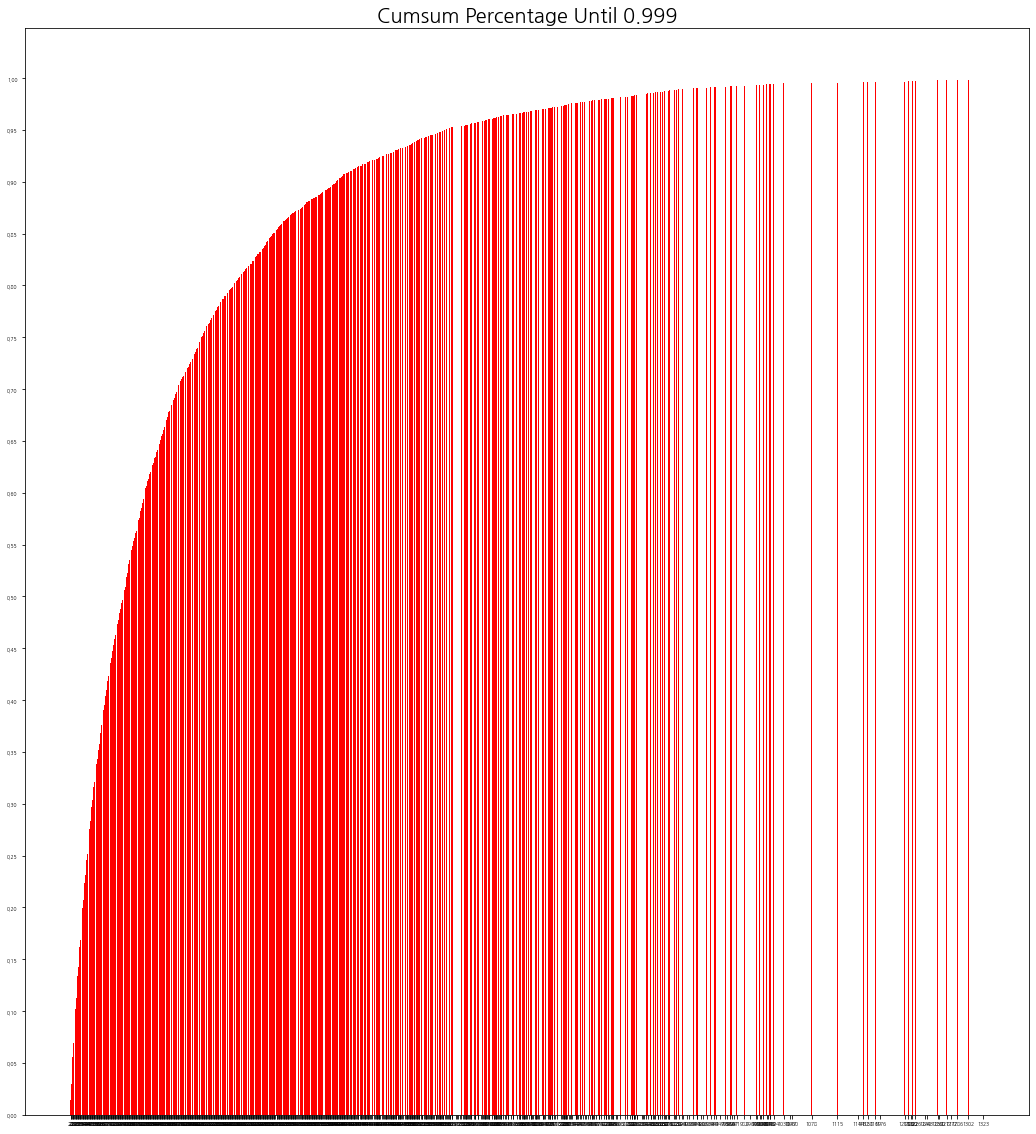

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.05),fontsize=5)
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## ItemId Length
- ItemId(영화)당 평점리뷰 횟수


In [13]:
itemId_length = data.groupby('ItemId').size()
itemId_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

### ItemId Length통계( )

In [14]:
# 길이 중앙값, 길이평균
itemId_length.median(), itemId_length.mean()

(123.5, 269.88909875876953)

In [15]:
# 최소길이, 최대길이
itemId_length.min(), itemId_length.max()

(1, 3428)

In [16]:
itemId_length.quantile(0.999)

2734.2450000001113

```
길이 중앙값      :  123.5
길이 평균       :  269.88
최소길이        :  1
최대길이        :  3428
세션길이99.9%   :  2734.24 이하의 길이를 갖는다.
```


### 가장 많은 평점리뷰를 받은 영화의 정보 확인
 - 가장 많은 평점리뷰 횟수를 받은 영화(item)을 long_session에 저장 
 - 3428 = ItemId

In [17]:
long_itemId = itemId_length[itemId_length == 3428].index[0]
df_tmp = data[data['ItemId'] == long_itemId]

In [18]:
df_tmp

,UserId,ItemId,Rating,Time
105,2,2858,4,2001-01-01 06:33:54
202,3,2858,4,2001-01-01 06:10:39
299,5,2858,4,2000-12-31 14:43:10
471,6,2858,1,2000-12-31 13:26:49
585,8,2858,5,2000-12-31 11:30:17
...,...,...,...,...
996998,6019,2858,5,2000-04-26 23:49:12
997895,6027,2858,3,2000-04-26 14:25:36
998845,6036,2858,5,2000-04-26 09:37:33
999571,6037,2858,4,2000-04-26 09:33:35


### 세션 길에 대한 시각화
- 세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 한다. 
- 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화 한것이다.

In [19]:
length_count = itemId_length.groupby(itemId_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.030761
2       0.054776
3       0.066109
4       0.078251
5       0.088775
          ...   
2583    0.997841
2590    0.998111
2649    0.998381
2653    0.998651
2672    0.998921
Length: 920, dtype: float64

In [20]:
length_percent_cumsum_80 = length_percent_cumsum[ length_percent_cumsum > 0.809]
length_percent_cumsum_80

450     0.809498
451     0.810577
452     0.811117
453     0.812196
454     0.812466
          ...   
2672    0.998921
2883    0.999191
2990    0.999460
2991    0.999730
3428    1.000000
Length: 491, dtype: float64

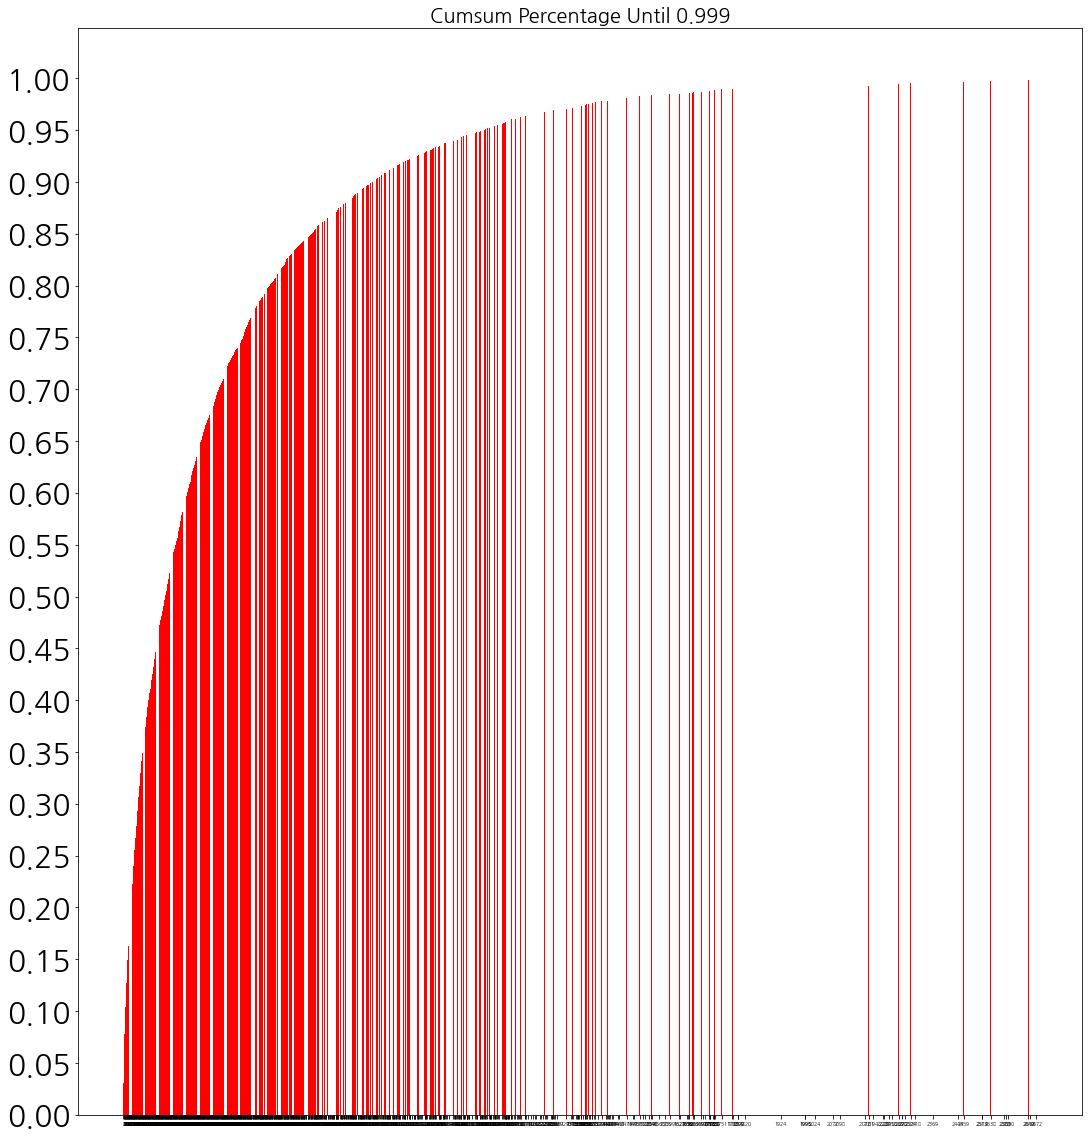

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.05),fontsize=30)
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## Session Time
노드 학습한 프로젝트는 4월부터 9월까지여서 데이터가 많았지만 이 평점데이터는 3월부터 4월까지의 밖에 데이터가없기때문에 굳이 데이터를 분리할 필요가 없다. 모든데이터를 사용한다.

### Time 데이터 확인해보기

In [22]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


In [23]:
print(type(latest))
latest

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2003-03-01 02:49:50')

#### latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [24]:
print(dt.timedelta(30)) 

30 days, 0:00:00


In [25]:
365//6

60

In [26]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  

In [27]:
print(type(month_ago))
month_ago

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2003-01-30 02:49:50')

```
latest    => 2003-03-01 02:49:50   
month_ago => 2003-01-30 02:49:50 
```

## Data Cleansing
1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다. 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.

In [28]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

## 유저 아이디 중 평점횟수가 적은 유저 제거(즉 전문가가 아닌 유저 제거)
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

## 영화중 평점의 횟수가 적은 영화 제거(즉 비주류의 영화 제거)
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data




#### UserId Length(유저ID 당 영화평가 횟수) 
```  
길이 중앙값      :  96.0
길이 평균       :  165.59
최소길이        :  20
최대길이        :  2314
세션길이99.9%   :  1343 이하의 길이를 갖는다.
```

#### ItemId Length(영화 당 평점리뷰 횟수)
```
길이 중앙값      :  123.5
길이 평균       :  269.88
최소길이        :  1
최대길이        :  3428
세션길이99.9%   :  2734.24 이하의 길이를 갖는다.
```


- UserId Length길이는 긴 유저는 영화 전문가 일것이다.  영화전문가 일수록 많은 평점리뷰를 남겼고, 그 평점에 대한 값도 적절할것이다. 
- ItemId Length는 말 그대로 해당영화에 대한 리뷰의 개수이다. 즉 유명한 영화일수록 길이가 길것이다.

In [29]:
data_test = cleanse_recursive(data, shortest=96, least_click=200)
data_tmp=data_test
data = data_test
data
# 1000209 => 670810

,UserId,ItemId,Rating,Time
148,2,21,1,2001-01-01 06:57:19
133,2,95,2,2001-01-01 07:02:23
93,2,110,5,2001-01-01 06:37:05
147,2,163,4,2001-01-01 06:56:49
149,2,165,3,2001-01-01 07:00:02
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 23:39:27
1000120,6040,3683,4,2000-06-14 17:34:56
1000178,6040,3703,4,2000-07-29 08:56:15
1000183,6040,3735,4,2000-06-14 17:34:14


# Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## 데이터 분리하기

In [30]:
session_last_time = data.groupby('UserId')['Time'].max()

In [31]:
session_last_time

UserId
2      2001-01-01 07:02:54
5      2000-12-31 16:09:45
8      2000-12-31 16:19:03
9      2000-12-31 10:37:58
10     2001-01-28 08:37:13
               ...        
6035   2000-04-26 10:47:20
6036   2000-04-26 22:19:56
6037   2000-04-27 11:17:20
6039   2000-04-26 23:07:09
6040   2001-08-20 22:44:15
Name: Time, Length: 2712, dtype: datetime64[ns]

In [32]:
final_time = data['Time'].max()
final_time

Timestamp('2003-03-01 02:49:50')

### 데이터 분리함수 split_by_date

In [33]:
def split_by_date(data: pd.DataFrame, n_days: int):
     #마지막날 = session_last_time
    final_time = data['Time'].max()
    # 세션아이디기준 time이 마지막인날
    session_last_time = data.groupby('UserId')['Time'].max()
    
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [34]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [35]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["UserId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

### 훈련,벨류데이션,테스트 데이터 정보 출력

In [36]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 562706
	 Sessions: 2415
	 Items: 2415
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-08-06 14:21:37

* valid Set Stats Info
	 Events: 28465
	 Sessions: 84
	 Items: 84
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-18 05:56:25

* test Set Stats Info
	 Events: 79639
	 Sessions: 213
	 Items: 213
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [37]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

In [38]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

## Session-Parallel Mini-Batch 를 구현해 봅니다.

###  1)SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [39]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.    
session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.       

In [40]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
148,2,21,1,2001-01-01 06:57:19,0
133,2,95,2,2001-01-01 07:02:23,1
93,2,110,5,2001-01-01 06:37:05,2
147,2,163,4,2001-01-01 06:56:49,3
149,2,165,3,2001-01-01 07:00:02,4
144,2,235,3,2001-01-01 06:49:11,5
111,2,265,4,2001-01-01 06:43:46,6
80,2,292,3,2001-01-01 07:02:03,7
172,2,318,5,2001-01-01 06:33:33,8
154,2,349,4,2001-01-01 06:57:19,9


In [41]:
tr_dataset.click_offsets

array([     0,    120,    260, ..., 562327, 562430, 562706], dtype=int32)

In [42]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2412, 2413, 2414])

### 2) SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
__iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [57]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=20):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [58]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
148,2,21,1,2001-01-01 06:57:19,0
133,2,95,2,2001-01-01 07:02:23,1
93,2,110,5,2001-01-01 06:37:05,2
147,2,163,4,2001-01-01 06:56:49,3
149,2,165,3,2001-01-01 07:00:02,4
144,2,235,3,2001-01-01 06:49:11,5
111,2,265,4,2001-01-01 06:43:46,6
80,2,292,3,2001-01-01 07:02:03,7
172,2,318,5,2001-01-01 06:33:33,8
154,2,349,4,2001-01-01 06:57:19,9


In [59]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다. input, output, mask의 감을 잡아 봅시다.

In [60]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0 120 240 240]
Label Item Idx are :       [  1 121 121 121]
Previous Masked Input Idx are []


# Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## Evaluation Metric


In [61]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture
모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

학습 진행률을 모니터링하기 위해 사용하는 tqdm 라이브러리가 설치되어 있지 않다면 다음과 같이 설치해 주세요.
```
! pip install tqdm
```

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [63]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [106]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args01 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args02 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args03 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)
args04 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)
args05 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args06 = Args(tr, val, test, batch_size=32, hsz=20, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args07 = Args(tr, val, test, batch_size=32, hsz=60, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [107]:
model01 = create_model(args01)
model02 = create_model(args02)
model03 = create_model(args03)
model04 = create_model(args04)
model05 = create_model(args05)
model06 = create_model(args04)
model07 = create_model(args05)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(128, 1, 1282)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    200100    
_________________________________________________________________
dropout_25 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_25 (Dense)             (128, 1282)               65382     
Total params: 265,482
Trainable params: 265,482
Non-trainable params: 0
_________________________________________________________________
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(64, 1, 1282)]           0         
__________________________________

# Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.


학습은 총 3epoch 진행되며, 

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 진행전 값을 확인해 주세요.

In [86]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### test_model 함수

In [91]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

## 첫번째 모델
- 배치 사이즈가 커서 에러가 뜬다. 배치사이즈를 64로 변경해준다.(두번째~4번째 모델)

args01 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [93]:
train_model(model01, args01)

Evaluation:   0%|          | 0/221 [00:00<?, ?it/s]


IndexError: index 84 is out of bounds for axis 0 with size 84

## 두번째 모델
args02 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)


In [97]:
train_model(model02, args02)

Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.297, train_loss=2.49]

	 - Recall@20 epoch 1: 0.959793
	 - MRR@20    epoch 1: 0.545379



Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.18]

	 - Recall@20 epoch 2: 0.971646
	 - MRR@20    epoch 2: 0.567856



Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.391, train_loss=2.17]

	 - Recall@20 epoch 3: 0.974340
	 - MRR@20    epoch 3: 0.572520



Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.297, train_loss=2.45]

	 - Recall@20 epoch 4: 0.975822
	 - MRR@20    epoch 4: 0.576973



Evaluation:  52%|█████▏    | 232/443 [00:16<00:15, 13.99it/s]

	 - Recall@20 epoch 5: 0.977169
	 - MRR@20    epoch 5: 0.578605



### Inference

In [98]:


test_model(model02, args02, test)

Evaluation:  83%|████████▎ | 1031/1241 [01:11<00:14, 14.45it/s]

	 - Recall@20: 0.985527
	 - MRR@20: 0.619479



## 세번째 모델
args03 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)

In [94]:
train_model(model03, args03)

Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.55] 

	 - Recall@20 epoch 1: 0.953462
	 - MRR@20    epoch 1: 0.534631



Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.43]

	 - Recall@20 epoch 2: 0.969356
	 - MRR@20    epoch 2: 0.564812



Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.27]

	 - Recall@20 epoch 3: 0.972993
	 - MRR@20    epoch 3: 0.572568



Train:   0%|          | 0/8754 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.29]

	 - Recall@20 epoch 4: 0.973801
	 - MRR@20    epoch 4: 0.576197



Evaluation:  52%|█████▏    | 232/443 [00:16<00:15, 13.92it/s]

	 - Recall@20 epoch 5: 0.974542
	 - MRR@20    epoch 5: 0.577340



### Inference

In [95]:
test_model(model03, args03, test)

Evaluation:  83%|████████▎ | 1031/1241 [01:11<00:14, 14.36it/s]

	 - Recall@20: 0.984269
	 - MRR@20: 0.615513



## 네번째 모델
args04 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)


In [96]:
train_model(model04, args04)

Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.219, train_loss=2.65] 

	 - Recall@20 epoch 1: 0.972391
	 - MRR@20    epoch 1: 0.565554



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.47]

	 - Recall@20 epoch 2: 0.979028
	 - MRR@20    epoch 2: 0.587870



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.41]

	 - Recall@20 epoch 3: 0.981425
	 - MRR@20    epoch 3: 0.593782



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.65]

	 - Recall@20 epoch 4: 0.982117
	 - MRR@20    epoch 4: 0.594917



Evaluation:  77%|███████▋  | 678/886 [00:28<00:08, 23.58it/s]

	 - Recall@20 epoch 5: 0.981748
	 - MRR@20    epoch 5: 0.597201



### Inference

In [88]:
test_model(model04, args04, test)

Evaluation:  83%|████████▎ | 1031/1241 [01:11<00:14, 14.43it/s]

	 - Recall@20: 0.983466
	 - MRR@20: 0.611192



## 다섯번째 모델
args05 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)



In [103]:
train_model(model05, args05)

Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.406, train_loss=2.08] 

	 - Recall@20 epoch 1: 0.974465
	 - MRR@20    epoch 1: 0.573156



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.438, train_loss=2.41]

	 - Recall@20 epoch 2: 0.979121
	 - MRR@20    epoch 2: 0.589392



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.65]

	 - Recall@20 epoch 3: 0.980411
	 - MRR@20    epoch 3: 0.594965



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.438, train_loss=2.31]

	 - Recall@20 epoch 4: 0.981056
	 - MRR@20    epoch 4: 0.597377



Evaluation:  77%|███████▋  | 678/886 [00:30<00:09, 22.48it/s]

	 - Recall@20 epoch 5: 0.981840
	 - MRR@20    epoch 5: 0.598834



### Inference

In [105]:
test_model(model05, args05, test)

Evaluation:  92%|█████████▏| 2285/2482 [01:36<00:08, 23.57it/s]

	 - Recall@20: 0.986146
	 - MRR@20: 0.619327



## 여섯번째 모델
##args06 = Args(tr, val, test, batch_size=32, hsz=20, drop_rate=0.1, lr=0.001, epochs=5, k=20)


In [108]:
train_model(model06, args06)

Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.9]   

	 - Recall@20 epoch 1: 0.972391
	 - MRR@20    epoch 1: 0.566275



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.219, train_loss=2.73]

	 - Recall@20 epoch 2: 0.978060
	 - MRR@20    epoch 2: 0.586261



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.56] 

	 - Recall@20 epoch 3: 0.979351
	 - MRR@20    epoch 3: 0.590008



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.5] 

	 - Recall@20 epoch 4: 0.981379
	 - MRR@20    epoch 4: 0.595539



Evaluation:  77%|███████▋  | 678/886 [00:28<00:08, 23.74it/s]

	 - Recall@20 epoch 5: 0.981149
	 - MRR@20    epoch 5: 0.596440



### Inference

In [109]:
test_model(model06, args06, test)

Evaluation:  92%|█████████▏| 2285/2482 [01:35<00:08, 24.02it/s]

	 - Recall@20: 0.986078
	 - MRR@20: 0.616600



## 일곱번째 모델

args07 = Args(tr, val, test, batch_size=32, hsz=60, drop_rate=0.1, lr=0.001, epochs=5, k=20)


In [110]:
train_model(model07, args07)

Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.68]

	 - Recall@20 epoch 1: 0.974880
	 - MRR@20    epoch 1: 0.571521



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.6]  

	 - Recall@20 epoch 2: 0.979581
	 - MRR@20    epoch 2: 0.590090



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.281, train_loss=2.41]

	 - Recall@20 epoch 3: 0.981241
	 - MRR@20    epoch 3: 0.593691



Train:   0%|          | 0/17509 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.37]

	 - Recall@20 epoch 4: 0.981840
	 - MRR@20    epoch 4: 0.596037



Evaluation:  77%|███████▋  | 678/886 [00:29<00:09, 22.83it/s]

	 - Recall@20 epoch 5: 0.982577
	 - MRR@20    epoch 5: 0.597347



### Inference

In [111]:
test_model(model07, args07, test)

Evaluation:  92%|█████████▏| 2285/2482 [01:34<00:08, 24.07it/s]

	 - Recall@20: 0.986461
	 - MRR@20: 0.617154



```
첫번째   batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
두번째   batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
세번째   batch_size=64, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)
네번째   batch_size=32, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)
다섯번째  batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
여섯번째  batch_size=32, hsz=20, drop_rate=0.1, lr=0.001, epochs=5, k=20)
일곱번째  batch_size=32, hsz=60, drop_rate=0.1, lr=0.001, epochs=5, k=20)
```
위와 같이 7번의 시도를 하였다.    
첫번째 경우 배치 사이즈를 128로 하였을때 에러가 났다. 그래서 배치사이즈 64로 줄여줬더니 잘 동작하였다. 그리고 위와 같은 실험을 했을때 일곱번째인 batch_size=32 , hsz=60,   drop_rate=0.1, lr=0.001  일때 가장 잘 나왔다.   

그리고 위 같이 처음 에포크할때 부터 recall수치가 높게 나왔다. 훈련데이터를 잘못 분리했다는 추측과 아니면 처음부터 데이터셋을 너무 잘줬다는 추측이된다. 전자라고 생각된다.


아무튼 이프로젝트에서 가장 중요한것은 밑 코드 부분인것같다. 
data = cleanse_recursive(data, shortest=21, least_click=1) 
shortest는 한사람 유저가 평점을 남긴 회수을 의미하고, least_click는 영화당 평점의 개수를 의미한다.즉 인기 있는 영화를 찾고자 한다면 shortest와 least_click가 너무 작으면 안될것 같다.